<a href="https://colab.research.google.com/github/Lu4nAlmeida/cnm-simnet/blob/main/notebooks/training_ldpm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Clone repo and add src modules
!git clone https://github.com/Lu4nAlmeida/cnm-simnet.git
%cd cnm-simnet
%cd notebooks
import sys
sys.path.append('../src')

Cloning into 'cnm-simnet'...
remote: Enumerating objects: 133, done.
remote: Counting objects: 100% (133/133), done.
remote: Compressing objects: 100% (94/94), done.
remote: Total 133 (delta 53), reused 95 (delta 29), pack-reused 0 (from 0)
Receiving objects: 100% (133/133), 25.41 MiB | 33.49 MiB/s, done.
Resolving deltas: 100% (53/53), done.
/content/cnm-simnet
/content/cnm-simnet/notebooks


In [2]:
# Import Dependencies
import torch
import matplotlib.pyplot as plt
import pickle as pk
import numpy as np
from simulate_ldpm import ProjectileMotionSimulation
from models import ProjectileMotionModelRNN
from utils import get_global_scalers
from generate_data import generate_ldpm_data as generate_data
import time
import math

In [3]:
# Data Parameters
num_dim = 2
time_step = 0.01
duration = 1.0
simulations = 100

shape = (int(duration / time_step), num_dim)

# Time steps as a NumPy array
delta_times = np.arange(0, duration, time_step)
delta_times = np.broadcast_to(delta_times[:, None], shape)

In [4]:
# Training Hyperparameters
num_epochs = 2000
learning_rate = 0.001
loss_fn = torch.nn.MSELoss()

# Model Architecture
NUM_HIDDEN_NEURONS = 128
NUM_HIDDEN_LAYERS = 2
in_features = num_dim * 2 + 2  # (vel_x, vel_y, acc_x, acc_y, mass, drg)     2D
out_features = num_dim * 3     # (pos_x, pos_y, vel_x, vel_y, frc_x, frc_y)  2D

In [5]:
# Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [6]:
X_scaler, y_scaler = get_global_scalers(num_dim, shape, delta_times)

In [7]:
# Create model and optimizer
model = ProjectileMotionModelRNN().to(device)

In [8]:
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4)

[Epoch    0] Train Loss: 0.002591 | Test Loss: 0.001386
[Epoch  100] Train Loss: 0.002583 | Test Loss: 0.001452
[Epoch  200] Train Loss: 0.001929 | Test Loss: 0.001496
[Epoch  300] Train Loss: 0.002299 | Test Loss: 0.001227
[Epoch  400] Train Loss: 0.002008 | Test Loss: 0.002126
[Epoch  500] Train Loss: 0.002078 | Test Loss: 0.000934
[Epoch  600] Train Loss: 0.001871 | Test Loss: 0.001468
[Epoch  700] Train Loss: 0.001681 | Test Loss: 0.000833
[Epoch  800] Train Loss: 0.002121 | Test Loss: 0.001338
[Epoch  900] Train Loss: 0.001987 | Test Loss: 0.000884


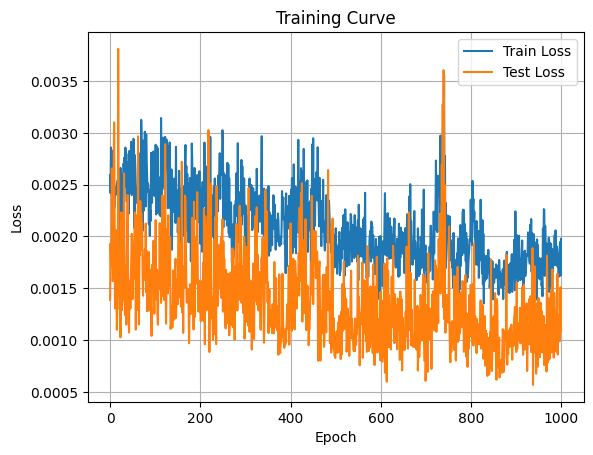

In [22]:
# Training Loop
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    X_train, y_train, X_test, y_test, *_ = generate_data(X_scaler, y_scaler, simulations, num_dim, shape, delta_times)

    X_train = X_train.to(device)
    y_train = y_train.to(device)
    X_test = X_test.to(device)
    y_test = y_test.to(device)

    model.train()

    optimizer.zero_grad()
    y_pred = model(X_train)
    loss = loss_fn(y_pred, y_train)
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())

    # Test loss (only one batch)
    model.eval()
    with torch.no_grad():
        test_pred = model(X_test)
        test_loss = loss_fn(test_pred, y_test).item()
        test_losses.append(test_loss)

    if epoch % 100 == 0:
        print(f"[Epoch {epoch:>4}] Train Loss: {loss.item():.6f} | Test Loss: {test_loss:.6f}")

# Plot the loss curve
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training Curve")
plt.grid(True)
plt.show()

In [23]:
def accuracy(expected, inferred, mode="rmse"):
    if mode == "rmse":
        error = math.sqrt(np.mean((expected - inferred) ** 2))
    elif mode == "mse":
        error = np.mean((expected - inferred) ** 2)
    elif mode == "mae":
        error = np.mean(np.abs(expected - inferred))

    accuracy = 1 / (error + 1)
    return accuracy * 100

In [24]:
# Make inference
sims = 1000
X_train, y_train, X_test, y_test, sim_time, total_time = generate_data(X_scaler, y_scaler, int(sims/0.2), num_dim, shape, delta_times)
X_test = X_test.to(device)
y_test = y_test.to(device)

start_time = time.perf_counter()
model.eval()
with torch.no_grad():
  test_pred = model(X_test)
  end_time = time.perf_counter()
  test_pred = test_pred.cpu().numpy()
  y_test = y_test.cpu().numpy()

pred_time = end_time - start_time

In [25]:
# Benchmarks
print(f"Simulations: {y_test.shape[0]}")
print(f"Simulation computed in {sim_time:.9f} seconds.")
print(f"Simulations total time {total_time:.9f} seconds.")
print(f"Simulation inferred in {pred_time:.9f} seconds.\n")

print(f"Accuracy (RMSE): {accuracy(y_test, test_pred,'rmse'):.2f}%")
print(f"Accuracy (MSE): {accuracy(y_test, test_pred, 'mse'):.2f}%")
print(f"Accuracy (MAE): {accuracy(y_test, test_pred, 'mae'):.2f}%")

Simulations: 1000
Simulation computed in 0.000078584 seconds.
Simulations total time 0.392921159 seconds.
Simulation inferred in 0.001193491 seconds.

Accuracy (RMSE): 96.97%
Accuracy (MSE): 99.90%
Accuracy (MAE): 97.83%


In [30]:
sim_times = []
total_times = []
pred_times = []

for num_sims in range(100, 2001, 100):
    X_train, y_train, X_test, y_test, sim_time, total_time = generate_data(X_scaler, y_scaler, int(num_sims/0.2), num_dim, shape, delta_times)
    X_test = X_test.to(device)
    y_test = y_test.to(device)

    start_time = time.perf_counter()
    model.eval()
    with torch.no_grad():
      test_pred = model(X_test)
      end_time = time.perf_counter()
      test_pred = test_pred.cpu().numpy()
      y_test = y_test.cpu().numpy()

    pred_time = end_time - start_time

    sim_times.append(sim_time)
    total_times.append(total_time)
    pred_times.append(pred_time)
    print(f"Simulations: {num_sims}")

Simulations: 100
Simulations: 200
Simulations: 300
Simulations: 400
Simulations: 500
Simulations: 600
Simulations: 700
Simulations: 800
Simulations: 900
Simulations: 1000
Simulations: 1100
Simulations: 1200
Simulations: 1300
Simulations: 1400
Simulations: 1500
Simulations: 1600
Simulations: 1700
Simulations: 1800
Simulations: 1900
Simulations: 2000


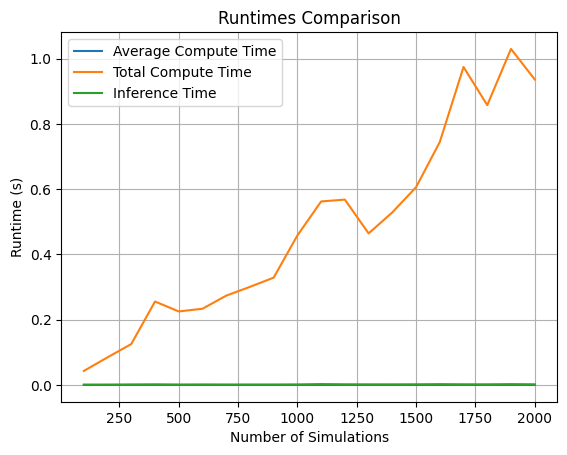

In [31]:
# Plot comparasion graph
plt.plot([i * 100 for i in range(1, len(sim_times) + 1)], sim_times, label="Average Compute Time")
plt.plot([i * 100 for i in range(1, len(total_times) + 1)], total_times, label="Total Compute Time")
plt.plot([i * 100 for i in range(1, len(pred_times) + 1)], pred_times, label="Inference Time")
plt.xlabel("Number of Simulations")
plt.ylabel("Runtime (s)")
plt.legend()
plt.title("Runtimes Comparison")
plt.grid(True)
plt.show()

In [15]:
def simulation_visualization(components, frames=shape[0], color="black"):
    for i in range(frames):
        pos = components[0][i], components[1][i]
        vel = components[2][i], components[3][i]
        frc = components[4][i], components[5][i]

        # Set axis limits dynamically
        plt.xlim(-5, 5)
        plt.ylim(-5, 5)

        if i == 0 or i == 99:
          # Plot velocity and acceleration vectors
          plt.quiver(pos[0], pos[1], frc[0]/2, frc[1]/2, color='orange', scale=15)  # Drag Force
          #plt.quiver(pos[0], pos[1], initial["acc"][0][0], initial["acc"][0][1], color='red', scale=15)  # Acceleration
          plt.quiver(pos[0], pos[1], vel[0]/2, vel[1]/2, color='blue', scale=15)  # Velocity

        # Plot particle position
        plt.scatter(pos[0], pos[1], color=color)

In [16]:
# Reshape the data to 2D before inverse transform
y_shape = y_test.shape
test_pred = test_pred.reshape(-1, test_pred.shape[-1])
y_test = y_test.reshape(-1, y_test.shape[-1])

y_pred = y_scaler.inverse_transform(test_pred)
y_test = y_scaler.inverse_transform(y_test)

# Reshape back to 3D after inverse transform
y_pred = y_pred.reshape(y_shape)
y_test = y_test.reshape(y_shape)

y_pred.shape, y_test.shape

((20, 100, 6), (20, 100, 6))

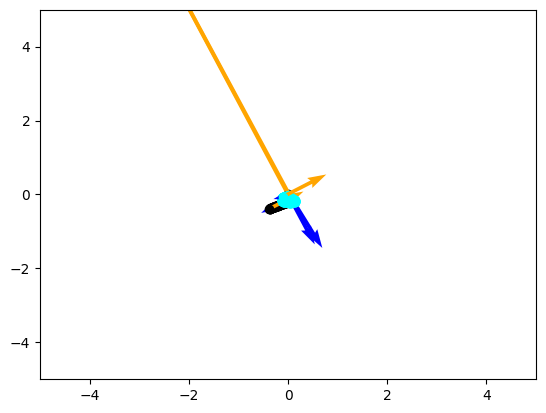

In [17]:
sim = 9

simulation_visualization(y_test[sim].T)
simulation_visualization(y_pred[sim].T, color="cyan")
plt.show()

In [18]:
ldpm = ProjectileMotionSimulation(
            pos=np.broadcast_to(np.zeros(num_dim), shape),
            vel=np.broadcast_to(np.array([7, 7]), shape),
            mass=np.full(shape, 0.2),
            acc=np.broadcast_to(np.array([0, -9]), shape),
            drg=np.full(shape, 2.6)
        )

ldpm.compute_output(delta_times)

inputs = np.concatenate([
    ldpm.vel,
    ldpm.acc,
    ldpm.mass[:, :-1],
    ldpm.drg[:, :-1],
], axis=1)
outputs = np.concatenate([
    ldpm.pos,
    ldpm.vel,
    ldpm.frc
], axis=1)

X = X_scaler.transform(inputs).reshape(1, shape[0], in_features)
y = y_scaler.transform(outputs).reshape(1, shape[0], out_features)

In [19]:
# Make inference
X = torch.tensor(X, dtype=torch.float32).to(device)
y = torch.tensor(y, dtype=torch.float32).to(device)

model.eval()
with torch.no_grad():
  y_pred = model(X)
  y_pred = y_pred.cpu().numpy()
  y = y.cpu().numpy()

In [20]:
# Reshape the data to 2D before inverse transform
y_pred = y_pred.reshape(shape[0], out_features)
y = y.reshape(shape[0], out_features)

y_pred = y_scaler.inverse_transform(y_pred)
y = y_scaler.inverse_transform(y)

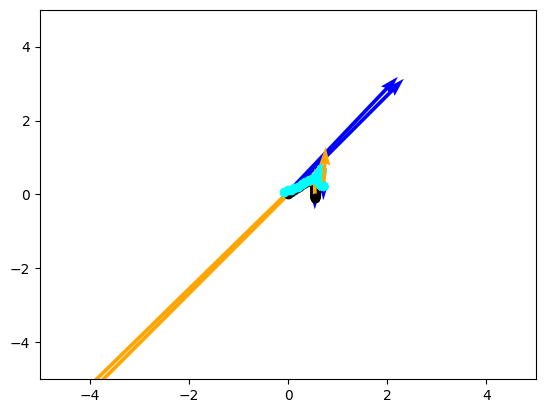

In [21]:
simulation_visualization(y.T)
simulation_visualization(y_pred.T, color="cyan")
plt.show()

In [ ]:
# Saving Model
torch.save(model.state_dict(), "/content/PMmodel_5.pth")
with open("scalers5.pkl", "wb") as f:
    pk.dump((X_scaler, y_scaler), f)